In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
import matplotlib as mpl

In [14]:
snap_list = ['100', '200', '300', '400', '500', '600']
lvl_list = ['3']
fields = ['Coordinates', 'Masses', 'StarFormationRate', 'Velocities']

snaps = {}
for lvl in lvl_list:
    snaps[lvl] = {}
    for sn in snap_list:
        snaps[lvl][sn] = arepo.Snapshot('lvl'+lvl+'/output', int(sn), combineFiles=True, parttype=[0], fields=fields)

In [13]:
fields = ['Coordinates', 'Masses', 'StarFormationRate', 'Velocities']

fname_old = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_archive/MeshReg-Rcore1.0_archive/lvl3/output/'
snap_old = arepo.Snapshot(fname_old, 0, combineFiles=True, parttype=[0, 2], fields=fields)

fname_new = '../runs/fRpoly-Rcore1.0-ringBug/lvl3/output/'
snap_new = arepo.Snapshot(fname_new, 0, combineFiles=True, parttype=[0, 2], fields=fields)

fname_new5 = '../runs/fRpoly-Rcore1.0/lvl5/ICs/output/'


In [3]:
def get_surface_profile(sn, PartType=0, center=np.array([200, 200, 200]), field='Masses'):
    part = getattr(sn, 'part0')
    pos = np.subtract(part.pos, center)
    mass = getattr(part, field)
    
    R = np.linalg.norm(pos[:,:2], axis=1)
    
    aveR_list = []
    surf_list = []
    
    Rbins = np.logspace(-1, 1.2, 15)
    for i in range(len(Rbins)-1):
        Rmin = Rbins[i]
        Rmax = Rbins[i+1]
        
        keys = np.where(np.logical_and(R > Rmin, R < Rmax))[0]
        totmass = np.sum(mass[keys])
        totarea = np.pi * (Rmax**2 - Rmin**2)
        
        aveR = np.mean(R[keys])
        
        surf = totmass / totarea
#         surf *= (1E10 / 1E6) # convert to Msun/pc^2
        
        aveR_list.append(aveR)
        surf_list.append(surf)
    
    return np.array(aveR_list), np.array(surf_list)
        

In [19]:
aveR_old, surf_old = get_surface_profile(snap_old)
aveR_new, surf_new = get_surface_profile(snap_new)

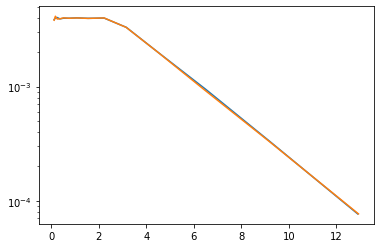

In [20]:
fig, ax = plt.subplots(1, 1)

ax.plot(aveR_old, surf_old)
ax.plot(aveR_new, surf_new)

ax.set(yscale='log')

plt.show()

In [18]:
def get_vdisp(sn, PartType=0, center=np.array([200, 200, 200])):
    part = getattr(sn, 'part'+str(PartType))
    pos = np.subtract(part.pos, center)
    try:
        mass = getattr(part, 'Masses')
    except:
        mass = np.full(sn.NumPart_Total[PartType], sn.MassTable[PartType])
    vel = getattr(part, 'Velocities')
    
    R = np.linalg.norm(pos[:,:2], axis=1)
    cphi = pos[:,0]/R
    sphi = pos[:,1]/R
    
    vR = vel[:,0]*cphi + vel[:,1]*sphi
    vphi = -vel[:,0]*sphi + vel[:,1]*cphi
    vz = vel[:,2]
    
    aveR_list = []
    vdisp_Rlist = []
    vdisp_philist = []
    vdisp_zlist = []
    vmean_Rlist = []
    vmean_philist = []
    vmean_zlist = []
    
    Rbins = np.logspace(-1, 1.2, 20)
    for i in range(len(Rbins)-1):
        Rmin = Rbins[i]
        Rmax = Rbins[i+1]
        
        keys = np.where(np.logical_and(R > Rmin, R < Rmax))[0]
        totmass = np.sum(mass[keys])
        totarea = np.pi * (Rmax**2 - Rmin**2)
        
        aveR = np.mean(R[keys])
        
        vdisp_R = np.square(np.std(vR[keys]))
        vdisp_phi = np.square(np.std(vphi[keys]))
        vdisp_z = np.square(np.std(vz[keys]))
        
#         vdisp_R = np.mean(np.square(vR[keys])) - np.square(np.mean(vR[keys]))
#         vdisp_phi = np.mean(np.square(vphi[keys])) - np.square(np.mean(vphi[keys]))
#         vdisp_z = np.mean(np.square(vz[keys])) - np.square(np.mean(vz[keys]))
        
        vmean_R, vmean_phi, vmean_z = np.mean(vR[keys]), np.mean(vphi[keys]), np.mean(vz[keys])
        
        surf = totmass / totarea
#         surf *= (1E10 / 1E6) # convert to Msun/pc^2
        
        aveR_list.append(aveR)
        vdisp_Rlist.append(vdisp_R)
        vdisp_philist.append(vdisp_phi)
        vdisp_zlist.append(vdisp_z)
        vmean_Rlist.append(vmean_R)
        vmean_philist.append(vmean_phi)
        vmean_zlist.append(vmean_z)
    
    return np.array(aveR_list), np.sqrt(vdisp_Rlist), np.sqrt(vdisp_philist), np.sqrt(vdisp_zlist),\
            np.transpose([vmean_Rlist, vmean_philist, vmean_zlist])
        

In [19]:
aveR_old, vdisp_R_old, vdisp_phi_old, vdisp_z_old, _ = get_vdisp(snap_old)
aveR_new, vdisp_R_new, vdisp_phi_new, vdisp_z_new, _ = get_vdisp(snap_new)

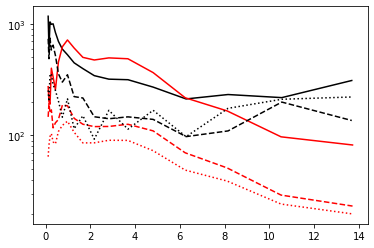

In [20]:
fig, ax = plt.subplots(1, 1)

ax.plot(aveR_old, vdisp_phi_old, c='k')
ax.plot(aveR_new, vdisp_phi_new, c='r')

ax.plot(aveR_old, vdisp_R_old, c='k', ls='dashed')
ax.plot(aveR_new, vdisp_R_new, c='r', ls='dashed')

ax.plot(aveR_old, vdisp_z_old, c='k', ls='dotted')
ax.plot(aveR_new, vdisp_z_new, c='r', ls='dotted')

ax.set(yscale='log')

plt.show()

In [22]:
snap_new.part0.vel[:,2]

Quantity([ 0.00637961, -0.00759278,  0.03027472, ...,  0.01582875,
          -0.0049783 ,  0.00095782], dtype=float32, unit=[km/s])

In [27]:
key = np.argmin(np.linalg.norm(snap_new.part2.pos - snap_new_MNDlvl3.part2.pos[10]))
print(snap_new.part2.vel[key])
print(snap_new_MNDlvl3.part2.vel[10])

[ 27.90964127 227.37173462  13.57482815]
[-202.91034   176.06035    15.888536]


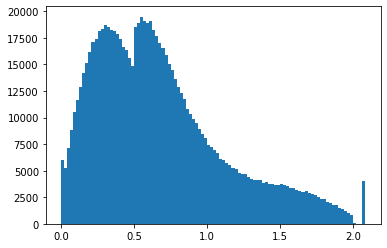

In [11]:
plt.hist(snap_old.part0.mass/7.5E-7, bins=100)
plt.show()

In [23]:
base_old = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_archive/MeshReg-Rcore1.0_archive/'

base_new = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/fRpoly-Rcore1.0/'

snap_old_MNDlvl4 = arepo.Snapshot(base_old+'lvl4/ICs/MW_ICs.dat')
snap_old_MNDlvl3 = arepo.Snapshot(base_old+'lvl3/ICs/MW_ICs.dat')
snap_new_MNDlvl4 = arepo.Snapshot(base_new+'lvl4/ICs/MW_ICs.dat')
snap_new_MNDlvl3 = arepo.Snapshot(base_new+'lvl3/ICs/MW_ICs.dat')

In [26]:
snap_new_MNDlvl3.part2.pos[10]

array([ 1.2709473 ,  3.5388548 , -0.43052652], dtype=float32)

0.44307916070000225
0.44307916070000225


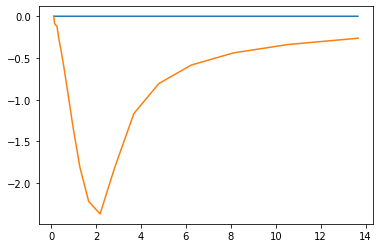

In [32]:
aveR_4o, vdisp_R_4o, vdisp_phi_4o, vdisp_z_4o, vmean_4o = get_vdisp(snap_old_MNDlvl4, center=np.array([0, 0, 0]))
aveR_3o, vdisp_R_3o, vdisp_phi_3o, vdisp_z_3o, vmean_3o = get_vdisp(snap_old_MNDlvl3, center=np.array([0, 0, 0]))
aveR_4n, vdisp_R_4n, vdisp_phi_4n, vdisp_z_4n, vmean_4n = get_vdisp(snap_new_MNDlvl4, center=np.array([0, 0, 0]))
aveR_3n, vdisp_R_3n, vdisp_phi_3n, vdisp_z_3n, vmean_3n = get_vdisp(snap_new_MNDlvl3, center=np.array([0, 0, 0]))

fig, ax = plt.subplots(1, 1)

# ax.plot(aveR_3o, vdisp_phi_3o, c='b')
# ax.plot(aveR_4o, vdisp_phi_4o, c='b', ls='dotted')
# ax.plot(aveR_3n, vdisp_phi_3n, c='r')
# ax.plot(aveR_4n, vdisp_phi_4n, c='b', ls='dotted')
# ax.plot(aveR_4n, vdisp_phi_4n - vdisp_phi_4o)
# ax.plot(aveR_3n, vdisp_phi_3n -vdisp_phi_3o, c='r')



# ax.plot(aveR_old, vdisp_R_4, c='k', ls='dashed')
# ax.plot(aveR_new, vdisp_R_new, c='r', ls='dashed')
#
# ax.plot(aveR_4o, vmean_4o[:,1], c='k')
# ax.plot(aveR_4n, vmean_4n[:,1], c='r', ls='dashed')
ax.plot(aveR_4n, vmean_4n[:,1] - vmean_4o[:,1])
# ax.plot(aveR_3o, vmean_3o[:,1], c='k')
# ax.plot(aveR_3n, vmean_3n[:,1], c='r', ls='dashed')
ax.plot(aveR_3n, vmean_3n[:,1] - vmean_3o[:,1])

# ax.set(yscale='log')

# print(snap_old_MNDlvl4.NumPart_Total[0]*snap_old_MNDlvl4.MassTable[0])
# print(snap_new_MNDlvl4.NumPart_Total[0]*snap_new_MNDlvl4.MassTable[0])

plt.show()

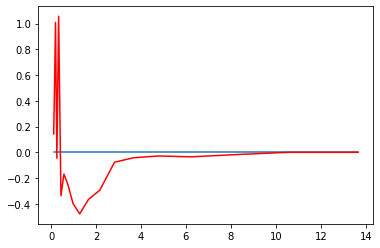

In [19]:
aveR_4o, vdisp_R_4o, vdisp_phi_4o, vdisp_z_4o, vmean_4o = get_vdisp(snap_old_MNDlvl4, PartType=2, center=np.array([0, 0, 0]))
aveR_3o, vdisp_R_3o, vdisp_phi_3o, vdisp_z_3o, vmean_3o = get_vdisp(snap_old_MNDlvl3, PartType=2, center=np.array([0, 0, 0]))
aveR_4n, vdisp_R_4n, vdisp_phi_4n, vdisp_z_4n, vmean_4n = get_vdisp(snap_new_MNDlvl4, PartType=2, center=np.array([0, 0, 0]))
aveR_3n, vdisp_R_3n, vdisp_phi_3n, vdisp_z_3n, vmean_3n = get_vdisp(snap_new_MNDlvl3, PartType=2, center=np.array([0, 0, 0]))

fig, ax = plt.subplots(1, 1)

# ax.plot(aveR_3o, vdisp_phi_3o, c='b')
# ax.plot(aveR_4o, vdisp_phi_4o, c='b', ls='dotted')
# ax.plot(aveR_3n, vdisp_phi_3n, c='r')
# ax.plot(aveR_4n, vdisp_phi_4n, c='b', ls='dotted')
# ax.plot(aveR_4n, vdisp_phi_4n - vdisp_phi_4o)
# ax.plot(aveR_3n, vdisp_phi_3n -vdisp_phi_3o, c='r')

# ax.plot(aveR_3o, vdisp_R_3o, c='b')
# ax.plot(aveR_4o, vdisp_R_4o, c='b', ls='dotted')
# ax.plot(aveR_3n, vdisp_R_3n, c='r')
# ax.plot(aveR_4n, vdisp_R_4n, c='r', ls='dotted')
ax.plot(aveR_4n, vdisp_R_4n - vdisp_R_4o)
ax.plot(aveR_3n, vdisp_R_3n -vdisp_R_3o, c='r')

# ax.plot(aveR_old, vdisp_R_4, c='k', ls='dashed')
# ax.plot(aveR_new, vdisp_R_new, c='r', ls='dashed')
#
# ax.plot(aveR_4o, vmean_4o[:,1], c='k')
# ax.plot(aveR_4n, vmean_4n[:,1], c='r', ls='dashed')

# ax.set(yscale='log')

plt.show()

In [30]:
base_fix = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/fRpoly-Rcore1.0/'
base_bug = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/fRpoly-Rcore1.0-ringBug/'

snap_fix_MNDlvl5 = arepo.Snapshot(base_fix+'lvl5/ICs/MW_ICs.dat')
snap_fix_MNDlvl4 = arepo.Snapshot(base_fix+'lvl4/ICs/MW_ICs.dat')
# snap_fix_MNDlvl3 = arepo.Snapshot(base_fix+'lvl3/ICs/MW_ICs.dat')
snap_bug_MNDlvl5 = arepo.Snapshot(base_bug+'lvl5/ICs/MW_ICs.dat')
snap_bug_MNDlvl4 = arepo.Snapshot(base_bug+'lvl4/ICs/MW_ICs.dat')
# snap_bug_MNDlvl3 = arepo.Snapshot(base_bug+'lvl3/ICs/MW_ICs.dat')

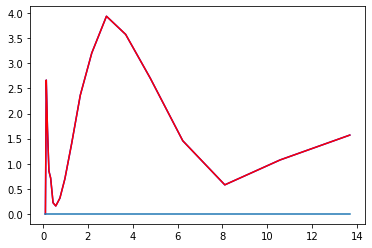

In [30]:
aveR_5b, vdisp_R_5b, vdisp_phi_5b, vdisp_z_5b, vmean_5b = get_vdisp(snap_bug_MNDlvl5, PartType=0, center=np.array([0, 0, 0]))
aveR_5f, vdisp_R_5f, vdisp_phi_5f, vdisp_z_5f, vmean_5f = get_vdisp(snap_fix_MNDlvl5, PartType=0, center=np.array([0, 0, 0]))
# aveR_4n, vdisp_R_4n, vdisp_phi_4n, vdisp_z_4n, vmean_4n = get_vdisp(snap_new_MNDlvl4, PartType=2, center=np.array([0, 0, 0]))
# aveR_3n, vdisp_R_3n, vdisp_phi_3n, vdisp_z_3n, vmean_3n = get_vdisp(snap_new_MNDlvl3, PartType=2, center=np.array([0, 0, 0]))

fig, ax = plt.subplots(1, 1)

ax.plot(aveR_5b, vdisp_phi_5b, c='b')
# ax.plot(aveR_4o, vdisp_phi_4o, c='b', ls='dotted')
ax.plot(aveR_5f, vdisp_phi_5f, c='r')
# ax.plot(aveR_4n, vdisp_phi_4n, c='b', ls='dotted')
ax.plot(aveR_5f, vdisp_phi_5b - vdisp_phi_5f)
# ax.plot(aveR_3n, vdisp_phi_3n -vdisp_phi_3o, c='r')

# ax.plot(aveR_3o, vdisp_R_3o, c='b')
# ax.plot(aveR_4o, vdisp_R_4o, c='b', ls='dotted')
# ax.plot(aveR_3n, vdisp_R_3n, c='r')
# ax.plot(aveR_4n, vdisp_R_4n, c='r', ls='dotted')
# ax.plot(aveR_4n, vdisp_R_4n - vdisp_R_4o)
# ax.plot(aveR_3n, vdisp_R_3n -vdisp_R_3o, c='r')

# ax.plot(aveR_old, vdisp_R_4, c='k', ls='dashed')
# ax.plot(aveR_new, vdisp_R_new, c='r', ls='dashed')
#
# ax.plot(aveR_4o, vmean_4o[:,1], c='k')
# ax.plot(aveR_4n, vmean_4n[:,1], c='r', ls='dashed')

# ax.set(yscale='log')

plt.show()

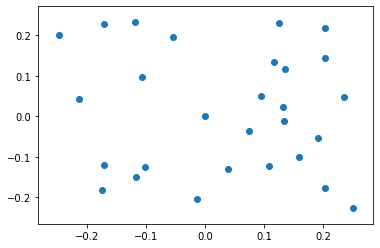

In [38]:
def plot_slice(snap, xmin=-0.25, xmax=0.25, ymin=-0.25, ymax=0.25, zmin=-0.1, zmax=0.1, center=np.array([0, 0, 0])):
    fig, ax = plt.subplots(1, 1)
    
    pos = snap.part0.pos - center
    xbool = np.logical_and(pos[:,0] > xmin, pos[:,0]<xmax)
    ybool = np.logical_and(pos[:,1] > ymin, pos[:,1]<ymax)
    zbool = np.logical_and(pos[:,2] > zmin, pos[:,2]<zmax)
    key = np.where(np.logical_and(np.logical_and(xbool, ybool), zbool))[0]
    
    pos_key = pos[key]
    
    ax.scatter(pos_key[:,0], pos_key[:,1])
    
    plt.show()
    return fig, ax
fig, ax = plot_slice(snap_fix_MNDlvl5)

In [33]:
fname_new5 = '../runs/fRpoly-Rcore1.0/lvl5/ICs/output/'
snap_new = arepo.Snapshot(fname_new, 20, combineFiles=True, parttype=[0, 2])


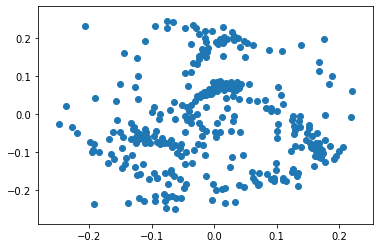

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b6ddedbab38>)

In [47]:
plot_slice(snap_new, center=np.array([200, 200, 200]), zmin=-0.002, zmax=0.002)

In [41]:
fname_new5 = '../runs/fRpoly-Rcore1.0/lvl5/ICs/output/'
snap_new0 = arepo.Snapshot(fname_new, 0, combineFiles=True, parttype=[0], fields=['Coordinates'])
snap_new1 = arepo.Snapshot(fname_new, 1, combineFiles=True, parttype=[0], fields=['Coordinates'])


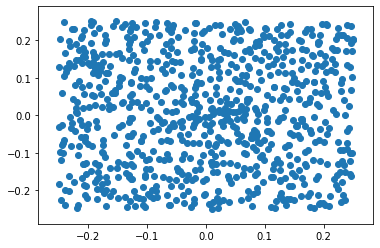

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2b6ddecdbb00>)

In [43]:
plot_slice(snap_new0, center=np.array([200, 200, 200]))